#Team Name: MIB
Team Captain: Muhammad Idman Barghoob

Team Members: Muhammad Idman Barghoob

Email id: ibarghoob@gmail.com

Used Google Colab for notebook environment, so most required libraries were pre-installed. Streamlit and ngrok will have to be installed using pip.

In [ ]:
! pip install tensorflow opencv-python streamlit

cloning repo for dataset

In [ ]:
! git clone https://github.com/iBarghoob/fer-may-hackathon

dataset path

In [41]:
import os

repo_path = '/content/fer-may-hackathon'

train_path = os.path.join(repo_path, 'images/train')
validation_path = os.path.join(repo_path, 'images/validation')

importing libraries

In [42]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

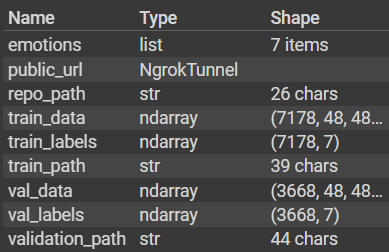

# Load and preprocess data

In [43]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# load training and testing images
def load_data(directory):
    data = []
    labels = []
    for i, emotion in enumerate(emotions):
      # get the corresponding emotion folder in the given directory (train / validation)
        emotion_dir = os.path.join(directory, emotion)
        for img_name in os.listdir(emotion_dir):
            img_path = os.path.join(emotion_dir, img_name)
            # get each image for corresponding emotion folder
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            data.append(img)
            labels.append(i)
    return np.array(data), np.array(labels)

# load training and validation images
train_data, train_labels = load_data(train_path)
val_data, val_labels = load_data(validation_path)

# normalize and reshape
train_data = train_data.reshape(-1, 48, 48, 1).astype('float32') / 255
val_data = val_data.reshape(-1, 48, 48, 1).astype('float32') / 255

train_labels = to_categorical(train_labels, 7)
val_labels = to_categorical(val_labels, 7)

# Build layers and train model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# sequential model
model = Sequential([
    # first layer with 32 filters
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),

    # second layer with 64 filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # third layer with 128 filters
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # flatten the output from the convolutional layers to feed into the dense layers
    Flatten(),
    # fully connected dense layer with 128 units and relu activation
    Dense(128, activation='relu'),
    Dropout(0.5),

    # output layer with 7 units (one for each emotion) and softmax activation to get probabilities for each class
    Dense(7, activation='softmax')
])

# train and save model
# compile model with Adam optimizer, accuracy as the metric for model evaluatoin
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=25, validation_data=(val_data, val_labels), batch_size=32)
model.save('emotion_recognition_model.h5')

Epoch 1/25
225/225 [==============================] - 28s 120ms/step - loss: 1.8412 - accuracy: 0.2360 - val_loss: 1.7876 - val_accuracy: 0.2710
Epoch 2/25
225/225 [==============================] - 25s 111ms/step - loss: 1.7957 - accuracy: 0.2534 - val_loss: 1.6926 - val_accuracy: 0.3427
Epoch 3/25
225/225 [==============================] - 30s 133ms/step - loss: 1.6934 - accuracy: 0.3312 - val_loss: 1.5699 - val_accuracy: 0.3776
Epoch 4/25
225/225 [==============================] - 27s 121ms/step - loss: 1.5877 - accuracy: 0.3840 - val_loss: 1.4498 - val_accuracy: 0.4537
Epoch 5/25
225/225 [==============================] - 26s 116ms/step - loss: 1.5294 - accuracy: 0.4023 - val_loss: 1.4096 - val_accuracy: 0.4686
Epoch 6/25
225/225 [==============================] - 28s 123ms/step - loss: 1.4780 - accuracy: 0.4333 - val_loss: 1.3285 - val_accuracy: 0.5068
Epoch 7/25
225/225 [==============================] - 26s 116ms/step - loss: 1.4130 - accuracy: 0.4570 - val_loss: 1.2792 - val_ac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Streamlit app using ngrok

In [ ]:
! pip install streamlit

In [49]:
%%writefile app.py


import streamlit as st
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import tempfile

# load trained model
model = load_model('facial_emotion_recognition_model.h5')

# emotions
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

st.title('Facial Emotion Recognition')
# vid file
uploaded_file = st.file_uploader("upload a video", type=["mp4", "mov", "avi"])

if uploaded_file is not None:
    # create temp file for storing and processing video
    tFile = tempfile.NamedTemporaryFile(delete=False)
    tFile.write(uploaded_file.read())

    capture = cv2.VideoCapture(tFile.name)

    stframe = st.empty()
    while capture.isOpened():
        _, frame = capture.read()
        if not _:
            break
        # convert frames to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # detect face in frame using haarcascase classifier
        faces = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml').detectMultiScale(gray_frame, 1.1, 4)

        for (x, y, w, h) in faces:
            # extract region of interest and resize for model
            roi = gray_frame[y:y+h, x:x+w]
            roi = cv2.resize(roi, (48, 48))
            roi = roi.astype('float32') / 255
            roi = np.expand_dims(roi, axis=0)
            roi = np.expand_dims(roi, axis=-1)

            # predict emotion for roi
            predictions = model.predict(roi)
            max_index = int(np.argmax(predictions))
            emotion = emotions[max_index]

            # label frame with preficted emotion and detection box
            cv2.putText(frame, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # display in streamlit
        stframe.image(frame, channels="BGR")

    capture.release()

Overwriting app.py


Tried to run the streamlit app using a different method with npx before but faced errors, therefore I used pyngrok for the streamlit url. The program however works as intended when run locally on a computer, with running 'streamlit run app.py' in directory terminal assuming required libraries are installed on the comptuer and the trained model is in same directory.

Used ngrok just for testing on colab environment

In [ ]:
! pip install pyngrok

In [ ]:
from pyngrok import ngrok

In [ ]:
ngrok.set_auth_token('2hHRf0cT3jWzttYjOarsbW0yRcf_2wWnsSLMQW1buugiK87ni')

In [ ]:
import subprocess
import time

# start streamlit server in the background
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8503"])
time.sleep(2)

# set up ngrok to tunnel the streamlit app
public_url = ngrok.connect(addr='8503')
print(public_url)

In [53]:
ngrok.kill()